##The Whole sale customer data is given

##1. Read the dataset to the python environment.
##2. Try out different clustering models in the Whole sale customer dataset.
##3. Find the optimum number of clusters in each model and create the model with the optimum number of clusters.
##4. Perform DBSCAN Clustering
##5. Also perform PCA for Dimensionality reduction.

#Step 1:Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

#Step 2:Load Dataset

In [ ]:
data = pd.read_csv("/content/Wholesale customers data.csv")

In [ ]:
# Display the first few rows of the dataset
#-------------------------------------------------
print(data.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


##Result:

The dataset has been successfully loaded. It contains the following columns:

- Channel: Customer Channel (1), (2)

- Region: Customer Region (1,2,3)

- Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen: Annual spending (monetary units) on various product categories.

#Step 4:Data Exploration, Cleaning and Visualization

In [ ]:
data.shape

(440, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [ ]:
#Statistical Summary
#----------------------
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [ ]:
#check for missing values
#-----------------------------
data.isnull().sum()

,0
Channel,0
Region,0
Fresh,0
Milk,0
Grocery,0
Frozen,0
Detergents_Paper,0
Delicassen,0


In [ ]:
data.duplicated().sum()

np.int64(0)

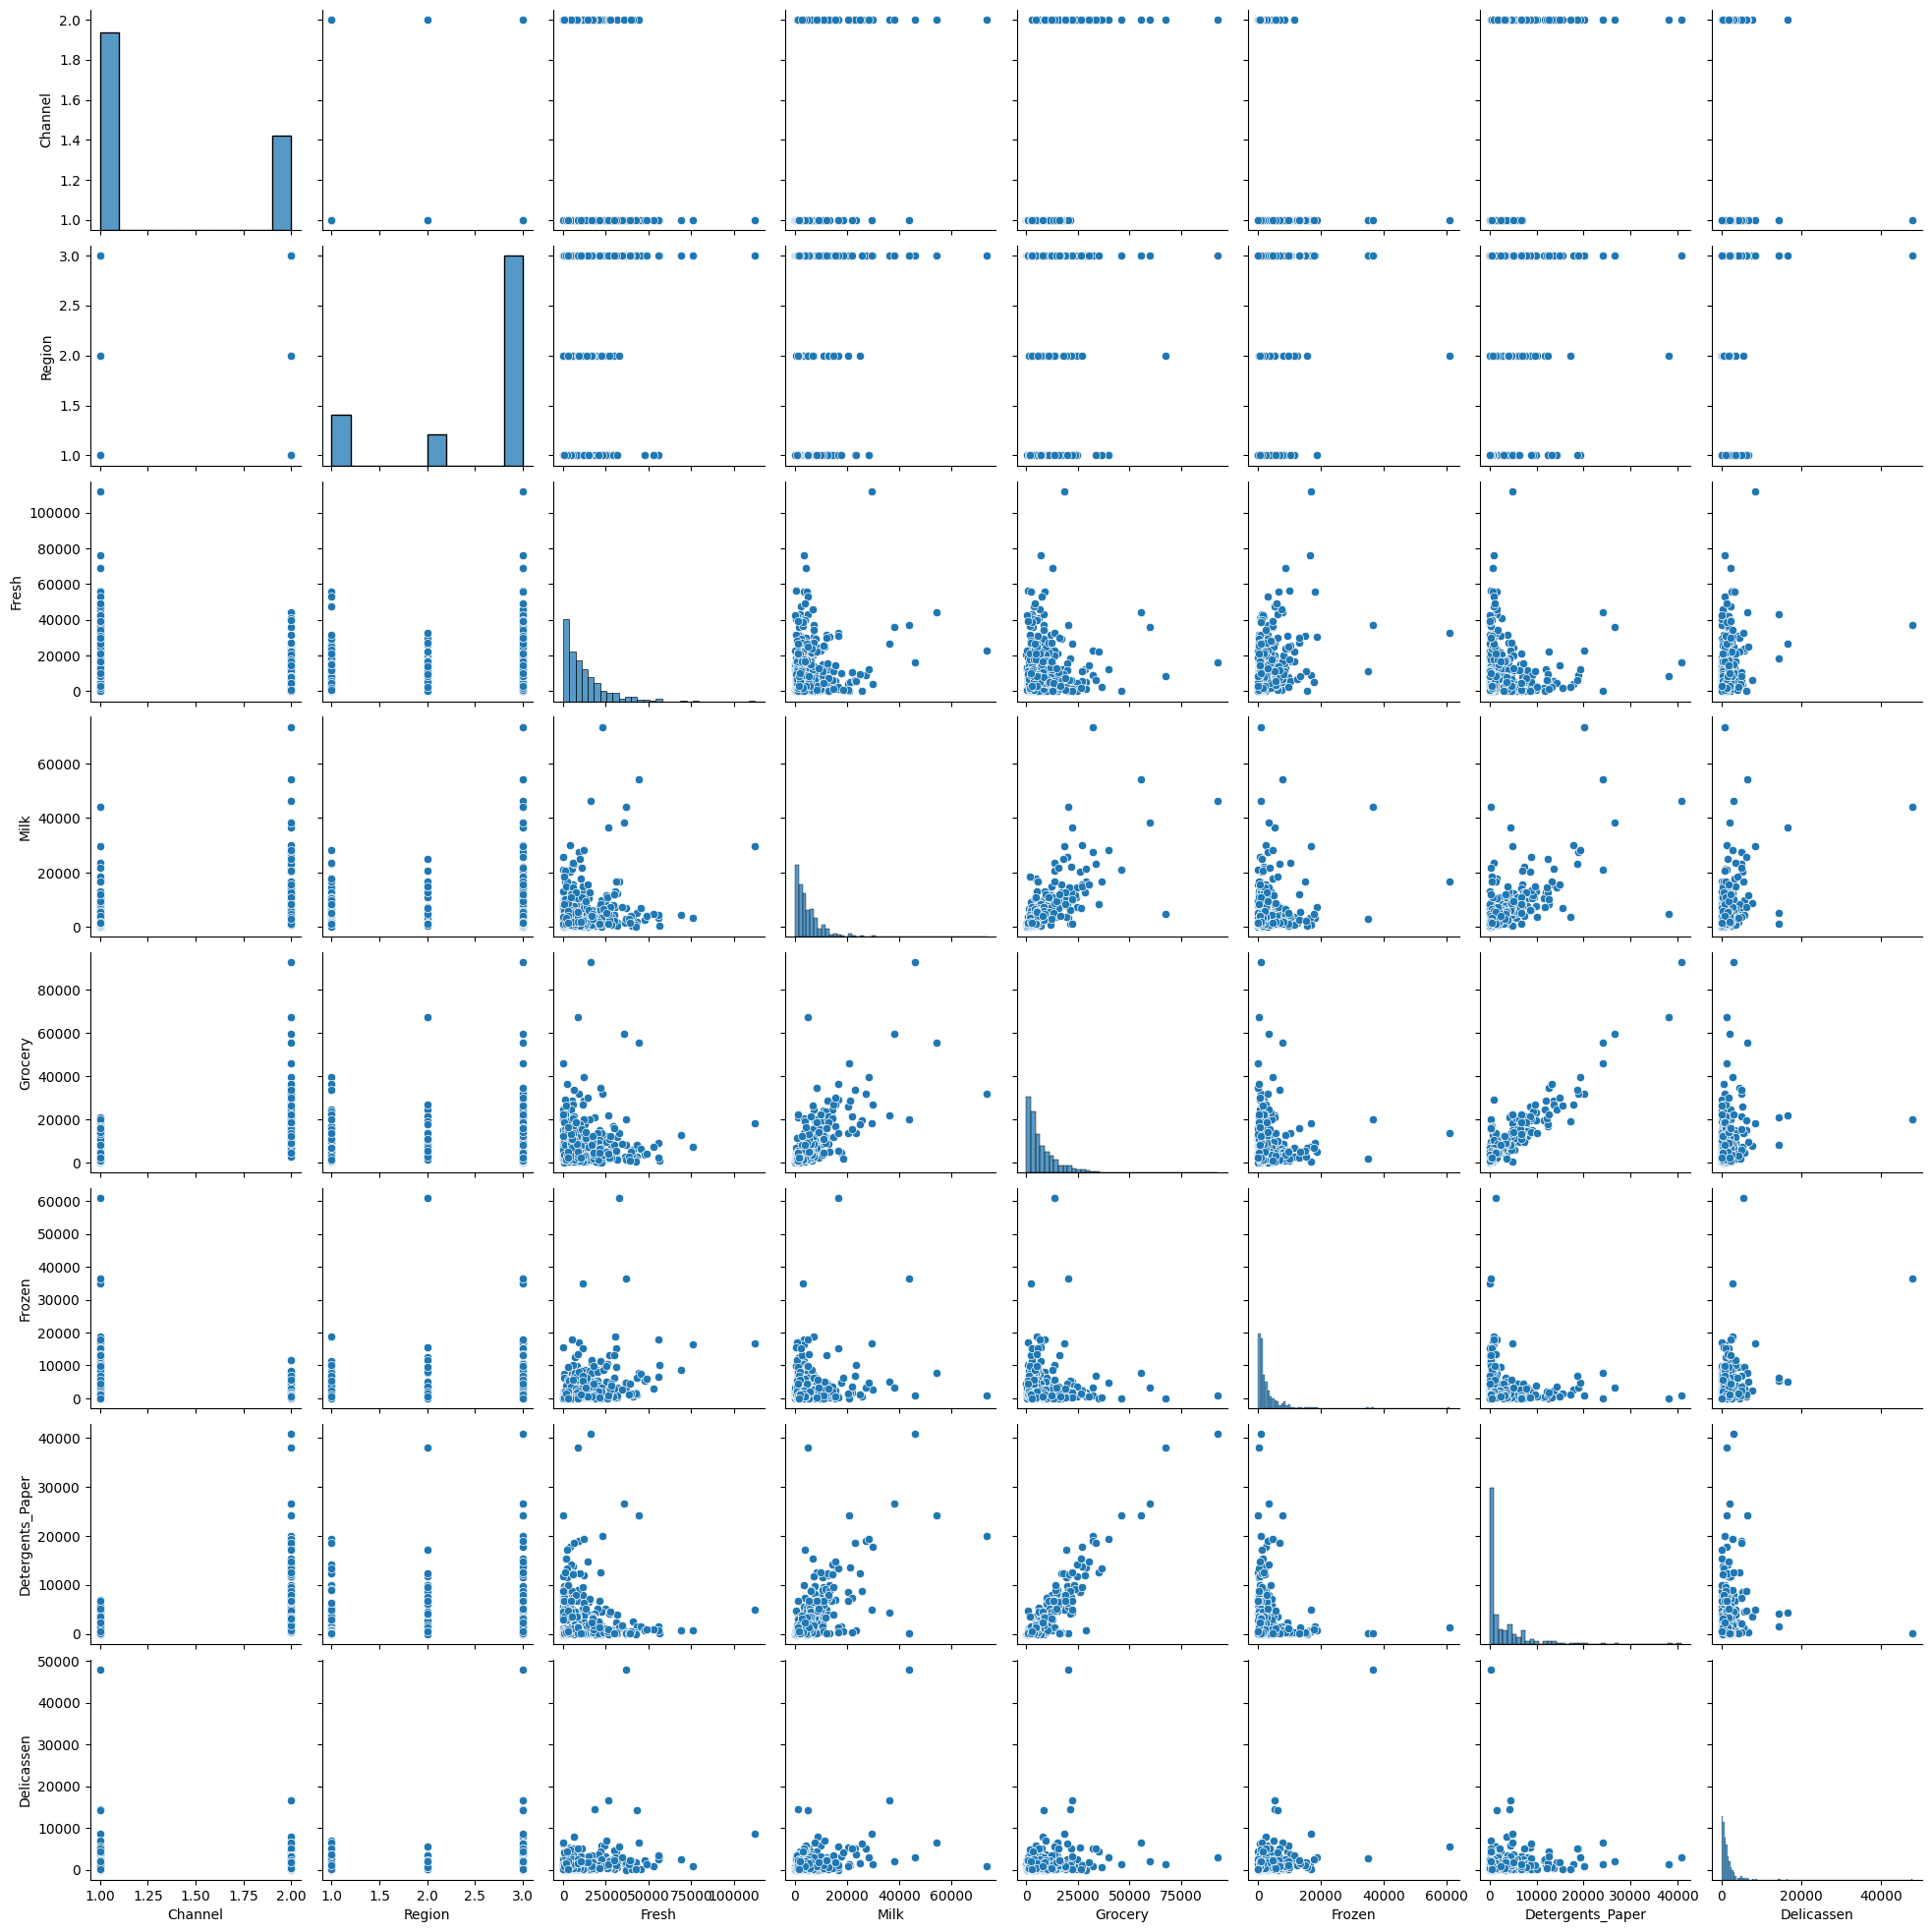

In [ ]:
# Visualize the distribution of each feature
sns.pairplot(data)
plt.show()

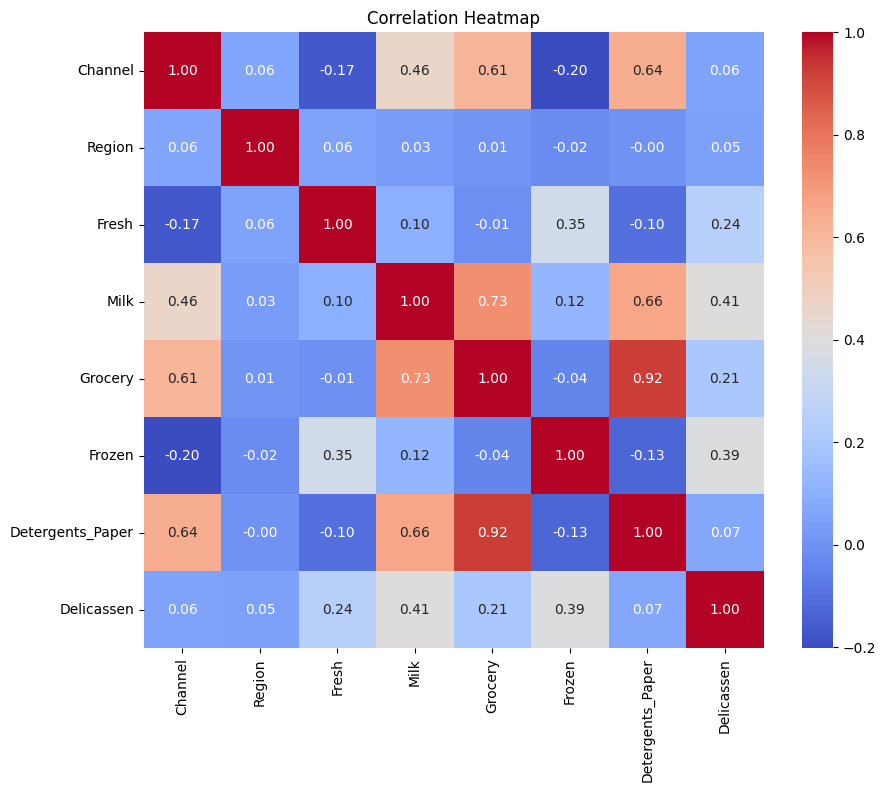

In [ ]:
# Correlation heatmap
#--------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
print(data['Channel'].value_counts())
print(data['Region'].value_counts())

Channel
1    298
2    142
Name: count, dtype: int64
Region
3    316
1     77
2     47
Name: count, dtype: int64


In [ ]:
correlation_matrix = data.corr()

# Set a threshold for high correlation
#----------------------------------------
threshold = 0.8

# Find pairs of features with high correlation
#---------------------------------------------
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.append((colname, correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

In [ ]:
# Display highly correlated pairs
#----------------------------------------
high_corr_pairs_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
print("Highly Correlated Features:")
print(high_corr_pairs_df)

# Step to decide which features to remove
#-----------------------------------------------
# Create a set to keep track of features to drop
features_to_remove = set()

for feature1, feature2, corr in high_corr_pairs:
    # Compare means to decide which feature to keep
    if data[feature1].mean() > data[feature2].mean():
        features_to_remove.add(feature2)  # Remove feature2
    else:
        features_to_remove.add(feature1)  # Remove feature1

# Display features to remove
#==================================
print("Features to remove based on correlation and mean values:")
print(features_to_remove)

Highly Correlated Features:
          Feature 1 Feature 2  Correlation
0  Detergents_Paper   Grocery     0.924641
Features to remove based on correlation and mean values:
{'Detergents_Paper'}


In [ ]:
#Drop Highly Correlated Feature
#------------------------------
data = data.drop(['Detergents_Paper'], axis=1)  # Remove due to high correlation with Grocery

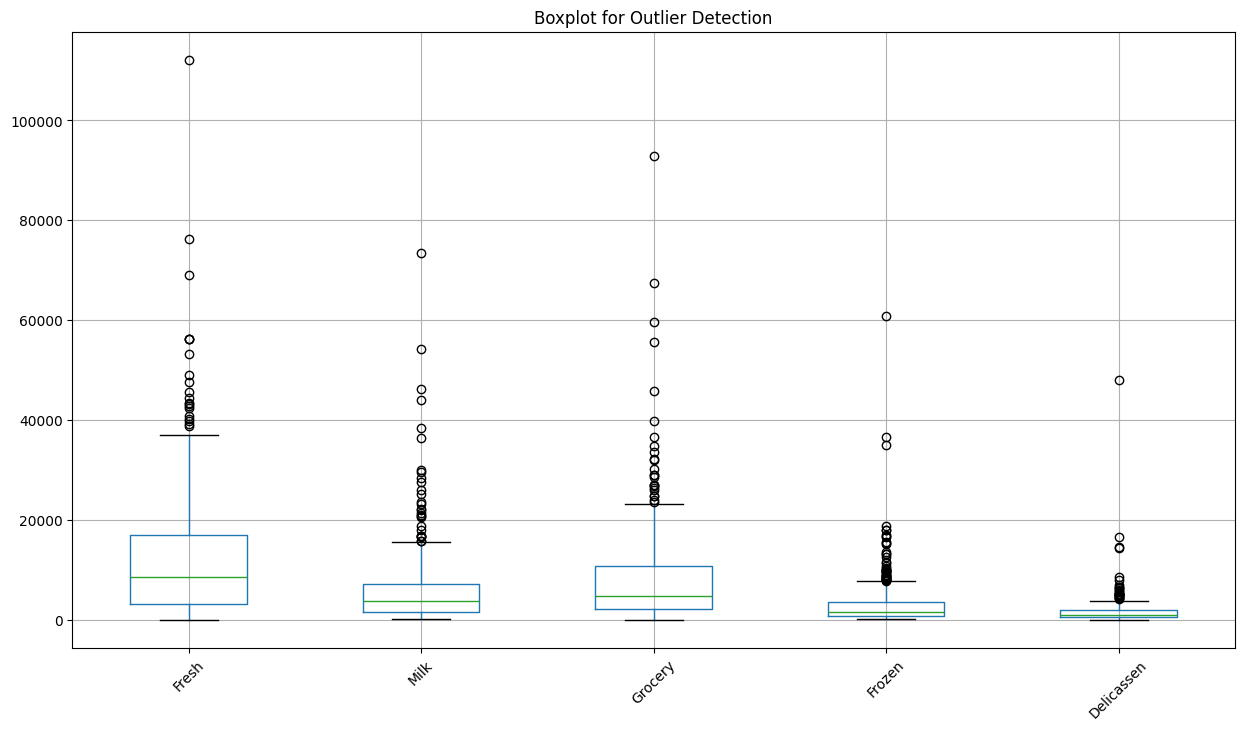

In [ ]:
#Outlier detection
#---------------------------
# Boxplots to detect outliers
#------------------------------
plt.figure(figsize=(15, 8))
data.drop(['Channel', 'Region'], axis=1).boxplot()
plt.title("Boxplot for Outlier Detection")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##_Outlier Handling (IQR) method_

In [ ]:
def remove_outliers_iqr(dat, features):
    for feature in features:
        Q1 = dat[feature].quantile(0.25)
        Q3 = dat[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        dat = dat[(dat[feature] >= lower_bound) & (dat[feature] <= upper_bound)]
    return dat


In [ ]:
continuous_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Delicassen']
data_clean = remove_outliers_iqr(data.copy(), continuous_features)

##Result:

Data Exploration:
No missing values

High variance in spending across features (e.g., Fresh, Milk, Grocery)

Boxplots and pairplots suggest presence of outliers, especially in Fresh and Delicassen

Correlation Matrix Summary:

| Feature 1   | Feature 2             | Correlation |                                |
| ----------- | --------------------- | ----------- | ------------------------------------------------ |
| **Grocery** | **Detergents\_Paper** | **0.92**    |
| **Milk**    | **Grocery**           | **0.73**    |
| **Milk**    | **Detergents\_Paper** | **0.66**    |



#Step 5:Data Pre-processing

In [ ]:
# Drop categorical features for clustering
#------------------------------------------
X = data_clean.drop(['Channel', 'Region'], axis=1)

# Standardize the features
#---------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Step 6:DBSCAN,K-Means clustering and Agglomerative

##_Find Optimal number of clusters_

In [ ]:
wcss = []
silhouette_scores_kmeans = []
silhouette_scores_agg = []
K_range = range(2, 11)

In [ ]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(X_scaled, kmeans_labels))

    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg_labels = agg.fit_predict(X_scaled)
    silhouette_scores_agg.append(silhouette_score(X_scaled, agg_labels))

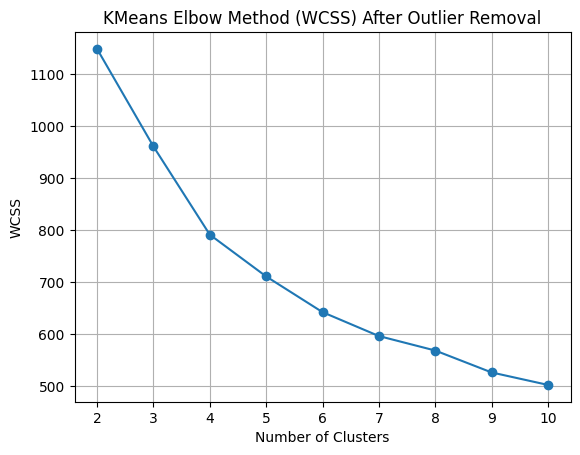

In [ ]:
# Plot Elbow and Silhouette
plt.figure()
plt.plot(K_range, wcss, marker='o')
plt.title("KMeans Elbow Method (WCSS) After Outlier Removal")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

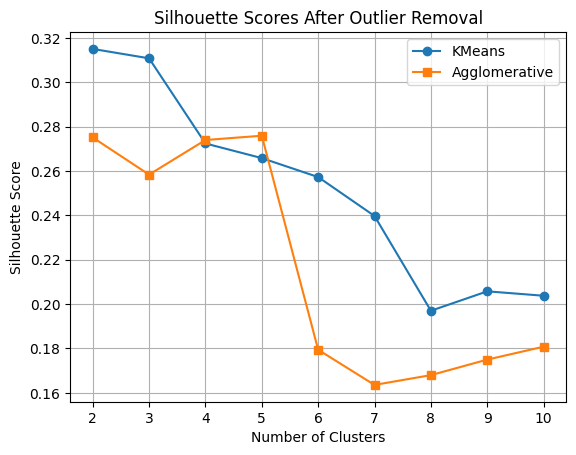

In [ ]:
plt.figure()
plt.plot(K_range, silhouette_scores_kmeans, label="KMeans", marker='o')
plt.plot(K_range, silhouette_scores_agg, label="Agglomerative", marker='s')
plt.title("Silhouette Scores After Outlier Removal")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimal_k_kmeans = K_range[silhouette_scores_kmeans.index(max(silhouette_scores_kmeans))]
optimal_k_agg = K_range[silhouette_scores_agg.index(max(silhouette_scores_agg))]

In [ ]:
# Apply Clustering
#-------------------
data_clean['KMeans_Cluster'] = KMeans(n_clusters=optimal_k_kmeans, random_state=42).fit_predict(X_scaled)
data_clean['Agglomerative_Cluster'] = AgglomerativeClustering(n_clusters=optimal_k_agg, linkage='ward').fit_predict(X_scaled)
data_clean['DBSCAN_Cluster'] = DBSCAN(eps=1.5, min_samples=5).fit_predict(X_scaled)

#Step 6:Apply PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_data = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_data['KMeans'] = data_clean['KMeans_Cluster']
pca_data['Agglomerative'] = data_clean['Agglomerative_Cluster']
pca_data['DBSCAN'] = data_clean['DBSCAN_Cluster']

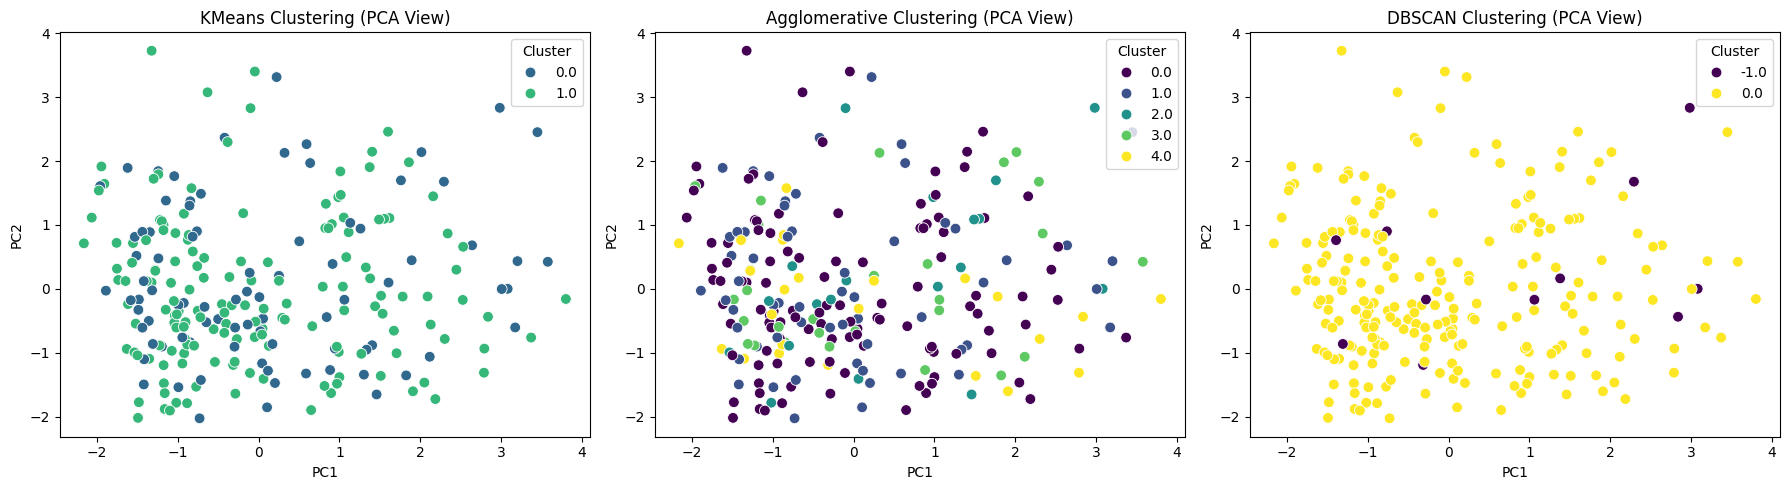

In [ ]:
# Plot PCA Clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, label in zip(axes, ['KMeans', 'Agglomerative', 'DBSCAN']):
    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue=label, ax=ax, palette='viridis', s=60)
    ax.set_title(f'{label} Clustering (PCA View)')
    ax.legend(title='Cluster')

plt.tight_layout()
plt.show()

#Step 7:Hierarchial Clustering

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
linked = linkage(X_scaled, method='ward')

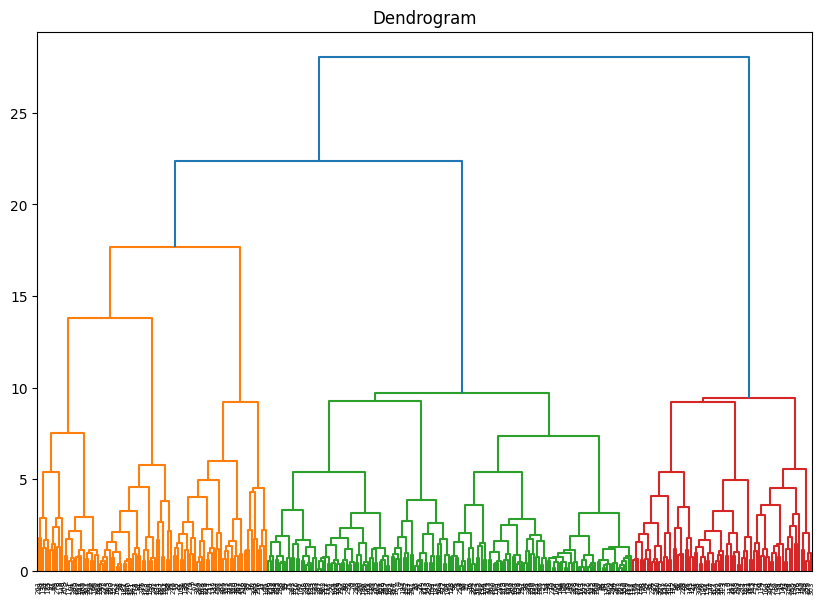

In [ ]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrogram')
plt.show()

#Step 8:Cluster analysis and comparison

In [ ]:
# -------------------Comparison of Clustering Labels -------------------
# Cross-tabulation to compare cluster assignments between methods
kmeans_vs_agg = pd.crosstab(data_clean['KMeans_Cluster'], data_clean['Agglomerative_Cluster'])
kmeans_vs_dbscan = pd.crosstab(data_clean['KMeans_Cluster'], data_clean['DBSCAN_Cluster'])
agg_vs_dbscan = pd.crosstab(data_clean['Agglomerative_Cluster'], data_clean['DBSCAN_Cluster'])

In [ ]:
# Show comparisons
kmeans_vs_agg, kmeans_vs_dbscan, agg_vs_dbscan

(Agglomerative_Cluster    0   1   2   3   4
 KMeans_Cluster                            
 0                        2  76   6  27   0
 1                      152   0  20  13  31,
 DBSCAN_Cluster  -1    0
 KMeans_Cluster         
 0               10  101
 1                5  211,
 DBSCAN_Cluster         -1    0
 Agglomerative_Cluster         
 0                       0  154
 1                       1   75
 2                       5   21
 3                       5   35
 4                       4   27)

#Final Result:

From the provided **confusion matrices (cross-tabulations)** between clustering methods, here's a detailed interpretation of what we can infer:

---

## **1. KMeans vs Agglomerative Clustering**

| **KMeans ↓ / Agglomerative →** | 0   | 1  | 2  | 3  | 4  |
| ------------------------------ | --- | -- | -- | -- | -- |
| **0**                          | 152 | 0  | 20 | 13 | 31 |
| **1**                          | 2   | 76 | 6  | 27 | 0  |

### **Insights:**

* **KMeans Cluster 0** aligns strongly with **Agglomerative Cluster 0** (152 members), but also overlaps with Agg 2, 3, 4.
* **KMeans Cluster 1** aligns mostly with **Agglomerative Cluster 1** (76 members), with additional members in Agg 3 (27).
* Indicates that **Agglomerative clustering has finer granularity** than KMeans — it splits the KMeans clusters into **smaller sub-clusters**.

🔍 **Interpretation**:
Agglomerative clustering captures more **sub-structure**, while KMeans clusters are broader. You can use Agglomerative when you want to identify **micro-segments**.

---

## **2. KMeans vs DBSCAN**

| **KMeans ↓ / DBSCAN →** | -1 (Noise) | 0 (Core Cluster) |
| ----------------------- | ---------- | ---------------- |
| **0**                   | 5          | 211              |
| **1**                   | 10         | 101              |

### **Insights:**

* DBSCAN identifies **15 outliers (noise)**: 5 from KMeans 0 and 10 from KMeans 1.
* The majority of data (\~312 samples) are grouped in **one big DBSCAN cluster (0)**.

🔍 **Interpretation**:
DBSCAN is useful for **outlier detection**. It doesn’t discover detailed clusters here — it treats most data as part of a **single dense region**, possibly due to default `eps`.

---

## **3. Agglomerative vs DBSCAN**

| **Agglomerative ↓ / DBSCAN →** | -1 | 0   |
| ------------------------------ | -- | --- |
| **0**                          | 0  | 154 |
| **1**                          | 1  | 75  |
| **2**                          | 5  | 21  |
| **3**                          | 5  | 35  |
| **4**                          | 4  | 27  |

### **Insights:**

* **DBSCAN Cluster 0** captures most members from all Agg clusters.
* DBSCAN marks **15 points as noise** scattered across Agg 1–4, suggesting **those clusters contain outliers**.
* **Agglomerative 0** aligns almost perfectly with DBSCAN 0 (154 of 154 samples).

🔍 **Interpretation**:
Agglomerative clustering finds **distinct sub-groups**, while DBSCAN simplifies the structure into **core cluster + noise**. Outliers are mostly in **Agglomerative clusters 2, 3, 4**.

---

## Final Conclusion:

| Method            | Strength                           | Weakness                                     |
| ----------------- | ---------------------------------- | -------------------------------------------- |
| **KMeans**        | Broad, clean segmentation          | Misses finer patterns, sensitive to outliers |
| **Agglomerative** | Good for **hierarchical patterns** | Can over-cluster if not pruned well          |
| **DBSCAN**        | Detects outliers effectively       | Poor when density isn’t varied enough        |
